<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/vae-segmentation/notebooks/Segmentation_Downstream_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation downstream task: SEN12FLOOD

Model: ResNetUnet \\
Data: SEN12FLOOD \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@vae-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision vae-segmentation) to /tmp/pip-install-7y99ch1i/ssl-remote-sensing_ec8857498e784e1e87d1cf23c3bff627
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-7y99ch1i/ssl-remote-sensing_ec8857498e784e1e87d1cf23c3bff627
  Running command git checkout -b vae-segmentation --track origin/vae-segmentation
  Switched to a new branch 'vae-segmentation'
  Branch 'vae-segmentation' set up to track remote branch 'vae-segmentation' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for ssl-remote-sensing: filename=ssl_remote_sensing-0.0.post1.dev146+gcfc8199-py3-none-any.whl size=39707 sha256=0d5d12a75f9c3becf9e6e331cf0aff8686d

In [2]:
!pip install rasterio torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# !pip install wandb

In [4]:
# # from ssl_remote_sensing.downstream_tasks.segmentatio
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [5]:
import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
dfc2020_path = '/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz'

In [10]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path='/content/')

In [17]:
# subset - 'val' 986
# subset - 'test' 5128

# train_set for sentinel-2
train_set = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 368900.78it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1150.tif 
 input shape: (13, 256, 256) 
 label shape: (256, 256) 



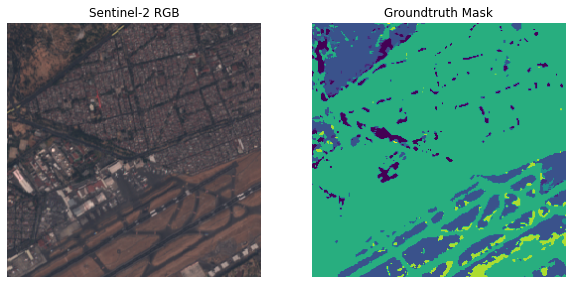

In [18]:
train_set.visualize_observation(170)

In [19]:
len(train_set)

5128

In [20]:
val_set = DFC2020('/content/dfc_data', subset="val", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)

[Load]: 100%|██████████| 986/986 [00:00<00:00, 325559.61it/s]

loaded 986 samples from the dfc2020 subset val


id: ROIs0000_validation_s2_0_p251.tif 
 input shape: (13, 256, 256) 
 label shape: (256, 256) 



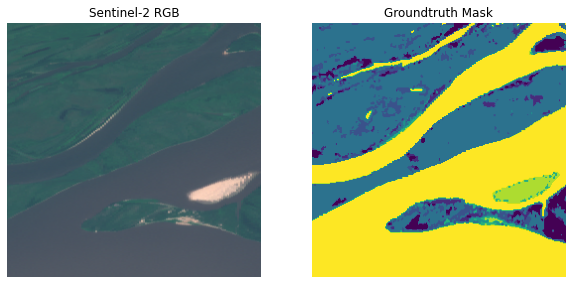

In [21]:
val_set.visualize_observation(170)

In [22]:
len(val_set)

986

In [23]:
train_loader = DataLoader(train_set,
                          batch_size=16,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [24]:
train_loader = DataLoader(val_set,
                          batch_size=16,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [ ]:
RANDOM_INITIALIZATION

'random'

In [21]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
# check_point_paths.append(RANDOM_INITIALIZATION)
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

NameError: ignored

In [ ]:
# for file in check_point_paths:
#   if file == '/content/drive/MyDrive/deep_learning_checkpoints/random':
#     print(file)

### Utils

In [ ]:
# def display_outputs(idx=None, multi=False):
#     # Pick a random index if none is specified
#     if not idx:
#         idx = random.randint(0, len(valset))
#     print('Validation image ID: {}'.format(idx))
    
#     # Get Sentinel 2 and Sentinel 1 data
#     s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
#     s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
    
#     # Get predictions from the model
#     if multi:
#         output = model(s1_data, s2_data)
#     else:
#         output = model(s2_data)
    
#     # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
#     output_binary = torch.zeros(output.shape)
#     output_binary[output >= 0] = 1
    
#     get_metrics(valset.__getitem__(idx)['mask'], output_binary)
    
#     fig, axes = plt.subplots(1, 3, figsize=(15, 7))
#     axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
#     axes[0].set_title('True Color Sentinel-2')
#     axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
#     axes[2].set_title('Groundtruth')
#     axes[1].imshow(output_binary.squeeze(), cmap='Blues')
#     axes[1].set_title('Predicted Mask')

### Hyperparameter setup

In [ ]:
# Model Setup
class Hparams:
    def __init__(self):
        # self.pretext_task = "VAE"
        #self.pretext_task = "SimCLR"
        # self.pretext_saved_name = 'autoencoder.ckpt'
        self.checkpoint_name = None
        #self.pretext_saved_name = 'SimCLR_ResNet18_adam-v3.ckpt'
        self.epochs = 10 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.save = "./saved_model"
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.latent_dim = 256
        self.optim = "Adam"
        self.embedding_size = 128  # papers value is 128
        self.temperature = 0.5  # 0.1 or 0.5
        self.weight_decay = 1e-6
        self.cuda = True  # use coda
        self.transform = False
        self.split = False

In [ ]:
train_config = Hparams()

In [ ]:
reproducibility(train_config)

### Directory & Wandb setup

## Data

SEN12FLOOD \\


*   13 Bands


In [ ]:
trainset = SEN12FLOODS(
        root='/content/chips/',
        transforms=True,
        split='train')

valset = SEN12FLOODS(
    root='/content/chips/', 
    split='val')


train_loader = DataLoader(
    trainset,
    batch_size=8,
    pin_memory=True)

val_loader = DataLoader(
    valset,
    batch_size=8,
    pin_memory=True)

Found 688 images in the folder /content/chips/train
Found 211 images in the folder /content/chips/val


In [ ]:
print("[LOG] Shape of mask image is:", next(iter(train_loader))["mask"].shape)
print("[LOG] Shape of sentinel-2 image is:", next(iter(train_loader))["s2_img"].shape)

[LOG] Shape of mask image is: torch.Size([8, 256, 256])
[LOG] Shape of sentinel-2 image is: torch.Size([8, 13, 256, 256])


/content/chips/train/8fcb3e59-7b1b-49c9-92c4-f4ddea14d4e4/s2/S2A_MSIL1C_20200805T085601_N0209_R007_T33MXU_20200805T112032_07168-08704
/content/chips/train/8fcb3e59-7b1b-49c9-92c4-f4ddea14d4e4/s1/S1A_IW_GRDH_1SDV_20200806T043438_20200806T043503_033781_03EA77_63A9_07168-08704


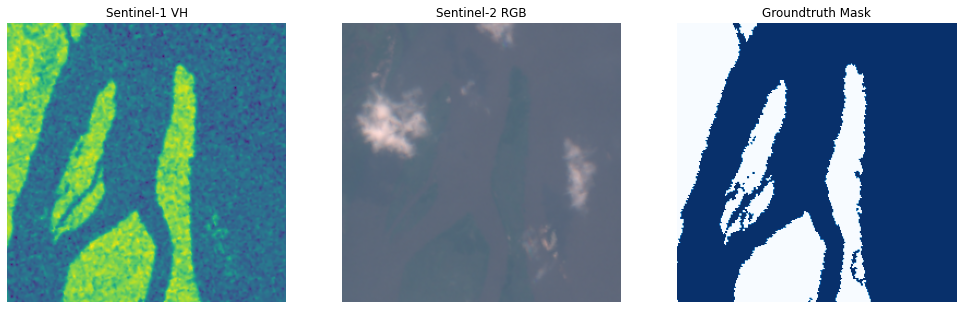

In [ ]:
trainset.visualize_observation(196)

/content/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s2/S2A_MSIL1C_20190331T170901_N0207_R112_T14TQL_20190331T222948_07680-09728
/content/chips/val/55d43c77-9955-4b4f-b6f0-b21e7f50a039/s1/S1A_IW_GRDH_1SDV_20190404T002124_20190404T002149_026633_02FCE5_A8E7_07680-09728


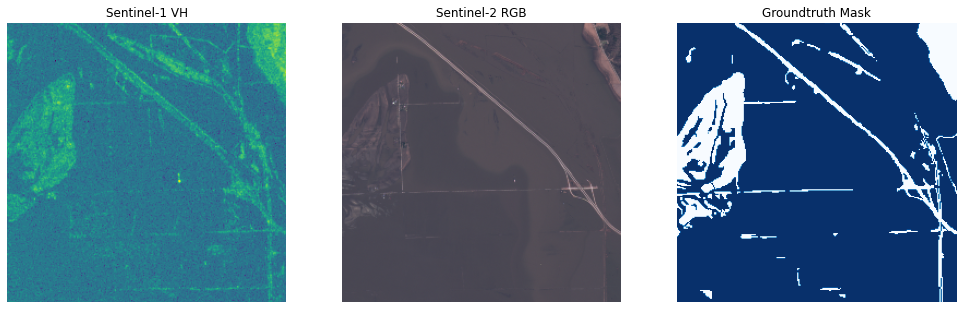

In [ ]:
valset.visualize_observation(127)

/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s2/S2A_MSIL1C_20180920T095021_N0206_R079_T31PGM_20180920T115741_09638-09042
/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s1/S1A_IW_GRDH_1SDV_20180921T175422_20180921T175447_023800_0298AE_A9BF_09638-09042


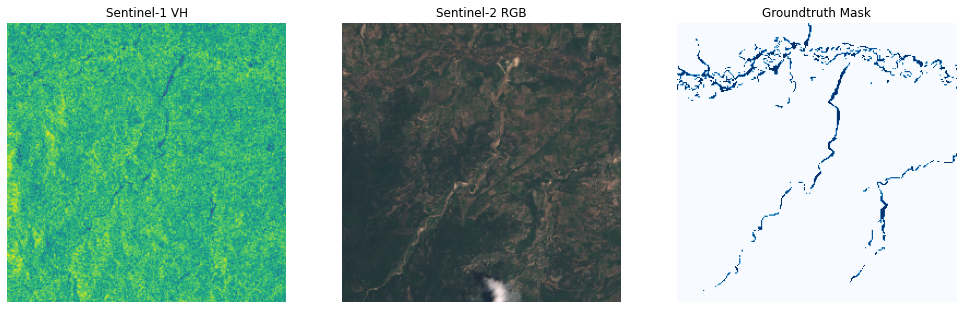

In [ ]:
valset.visualize_observation(42)

/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s2/S2A_MSIL1C_20180920T095021_N0206_R079_T31PHK_20180920T115741_02792-04293
/content/chips/val/975ecc1f-bc34-4005-b2df-ef45775f116d/s1/S1A_IW_GRDH_1SDV_20180921T175357_20180921T175422_023800_0298AE_52A3_02792-04293


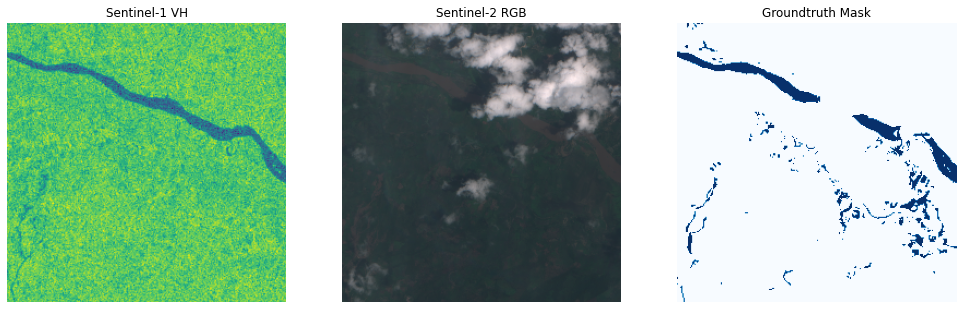

In [ ]:
valset.visualize_observation(37)

## Model

In [ ]:
# First of all, let's verify if a GPU is available on our compute machine. If not, the cpu will be used instead.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used: {}".format(device))
# Define a learning rate
learning_rate = train_config.lr
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

Device used: cuda:0


In [ ]:
# Initialise the loss function and move it to the GPU if available 
criterion = torch.nn.BCEWithLogitsLoss().to(device)

In [ ]:
next(iter(train_loader))["s2_img"].shape

torch.Size([8, 13, 256, 256])

In [ ]:
# load_encoder_checkpoint_from_pretext_model(
#         path_to_checkpoint='/content/drive/MyDrive/deep_learning_checkpoints/random'
#     )

In [ ]:
# for file in check_point_paths:
#     print(file)
#     print(load_encoder_checkpoint_from_pretext_model(
#         path_to_checkpoint=file
#     ))

Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
New module:  Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.4145: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.6121, val_iou is 0.6840
train_acc is 0.5271, val_acc is 0.5107


Validation Loss: 0.1220: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


Saving Model...
train_iou is 0.6449, val_iou is 0.7678
train_acc is 0.5377, val_acc is 0.4998


Validation Loss: 0.2718: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7148, val_iou is 0.6697
train_acc is 0.5468, val_acc is 0.5123


Validation Loss: 0.1317: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


train_iou is 0.7061, val_iou is 0.7485
train_acc is 0.5500, val_acc is 0.5043


Validation Loss: 0.1302: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


train_iou is 0.7245, val_iou is 0.7543
train_acc is 0.5479, val_acc is 0.5038


Validation Loss: 0.1330: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7311, val_iou is 0.7482
train_acc is 0.5503, val_acc is 0.5047


Validation Loss: 0.1278: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.7317, val_iou is 0.7558
train_acc is 0.5464, val_acc is 0.5035


Validation Loss: 0.1283: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7337, val_iou is 0.7486
train_acc is 0.5484, val_acc is 0.5047


Validation Loss: 0.1358: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


train_iou is 0.7217, val_iou is 0.7403
train_acc is 0.5472, val_acc is 0.5054


Validation Loss: 0.1230: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]


train_iou is 0.7303, val_iou is 0.7439
train_acc is 0.5480, val_acc is 0.5053
Finished Training
Sample image:  SimCLR_ResNet18_adam-v3
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 0.998
Class 1 (water) accuracy: 0.419
Overall accuracy: 0.965
Equally Weighted accuracy: 0.709
IoU: 0.406
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.796
Class 1 (water) accuracy: 0.986
Overall accuracy: 0.961
Equally Weighted accuracy: 0.891
IoU: 0.956
*******************************************
Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
New module:  Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▄▇█▇█▇▇▇▇
train_iou_segmentation,▁▃▇▆▇███▇█
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,▇▁█▄▃▄▃▄▄▄
val_iou_segmentation,▂█▁▇▇▇▇▇▆▆
val_loss_segmentation,█▁▅▁▁▁▁▁▁▁
train_acc_segmentation,0.54797
train_iou_segmentation,0.73029
train_loss_segmentation,0.11371
val_acc_segmentation,0.50528
val_iou_segmentation,0.74395


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.2742: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


train_iou is 0.5972, val_iou is 0.5067
train_acc is 0.5256, val_acc is 0.5263


Validation Loss: 0.2685: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Saving Model...
train_iou is 0.7242, val_iou is 0.5881
train_acc is 0.5471, val_acc is 0.5197


Validation Loss: 0.2793: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


train_iou is 0.7112, val_iou is 0.6151
train_acc is 0.5438, val_acc is 0.5171


Validation Loss: 0.1537: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


Saving Model...
train_iou is 0.7160, val_iou is 0.7643
train_acc is 0.5387, val_acc is 0.5013


Validation Loss: 0.1498: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


Saving Model...
train_iou is 0.7199, val_iou is 0.7732
train_acc is 0.5381, val_acc is 0.4970


Validation Loss: 0.1680: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7388, val_iou is 0.7373
train_acc is 0.5439, val_acc is 0.5051


Validation Loss: 0.2168: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7152, val_iou is 0.6836
train_acc is 0.5469, val_acc is 0.5104


Validation Loss: 0.1421: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Saving Model...
train_iou is 0.7337, val_iou is 0.7500
train_acc is 0.5440, val_acc is 0.5035


Validation Loss: 0.1221: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Saving Model...
train_iou is 0.7301, val_iou is 0.7802
train_acc is 0.5467, val_acc is 0.4935


Validation Loss: 0.1343: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7583, val_iou is 0.7570
train_acc is 0.5435, val_acc is 0.5012
Finished Training
Sample image:  SimCLR_ResNet18_adam_bs640-v1
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 0.998
Class 1 (water) accuracy: 0.349
Overall accuracy: 0.961
Equally Weighted accuracy: 0.674
IoU: 0.339
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.595
Class 1 (water) accuracy: 0.997
Overall accuracy: 0.944
Equally Weighted accuracy: 0.796
IoU: 0.939
*******************************************
Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
New module:  Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁█▇▅▅▇█▇█▇
train_iou_segmentation,▁▇▆▆▆▇▆▇▇█
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,█▇▆▃▂▃▅▃▁▃
val_iou_segmentation,▁▃▄██▇▆▇█▇
val_loss_segmentation,███▂▂▃▅▂▁▂
train_acc_segmentation,0.54345
train_iou_segmentation,0.75833
train_loss_segmentation,0.11017
val_acc_segmentation,0.50123
val_iou_segmentation,0.75701


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.2233: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


train_iou is 0.5880, val_iou is 0.6338
train_acc is 0.5306, val_acc is 0.5158


Validation Loss: 0.2059: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Saving Model...
train_iou is 0.6323, val_iou is 0.7868
train_acc is 0.5418, val_acc is 0.4968


Validation Loss: 0.1419: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


Saving Model...
train_iou is 0.7348, val_iou is 0.7725
train_acc is 0.5453, val_acc is 0.5014


Validation Loss: 0.1688: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


train_iou is 0.7292, val_iou is 0.7797
train_acc is 0.5427, val_acc is 0.4999


Validation Loss: 0.2330: 100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


train_iou is 0.7408, val_iou is 0.7029
train_acc is 0.5442, val_acc is 0.5091


Validation Loss: 0.1581: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7334, val_iou is 0.7444
train_acc is 0.5429, val_acc is 0.5054


Validation Loss: 0.1699: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7423, val_iou is 0.7452
train_acc is 0.5397, val_acc is 0.5050


Validation Loss: 0.1187: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Saving Model...
train_iou is 0.7557, val_iou is 0.7862
train_acc is 0.5466, val_acc is 0.4995


Validation Loss: 0.1256: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7370, val_iou is 0.7915
train_acc is 0.5387, val_acc is 0.4950


Validation Loss: 0.1728: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


train_iou is 0.6821, val_iou is 0.7858
train_acc is 0.5309, val_acc is 0.4910
Finished Training
Sample image:  SimCLR_ResNet18_adam_bs2250-v1
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.429
Overall accuracy: 0.967
Equally Weighted accuracy: 0.714
IoU: 0.427
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.737
Class 1 (water) accuracy: 0.994
Overall accuracy: 0.960
Equally Weighted accuracy: 0.866
IoU: 0.956
*******************************************
Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
New module:  Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▆▇▆▇▆▅█▅▁
train_iou_segmentation,▁▃▇▇▇▇▇█▇▅
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,█▃▄▃▆▅▅▃▂▁
val_iou_segmentation,▁█▇▇▄▆▆███
val_loss_segmentation,▇▆▂▄█▃▄▁▁▄
train_acc_segmentation,0.53088
train_iou_segmentation,0.68211
train_loss_segmentation,0.32491
val_acc_segmentation,0.49102
val_iou_segmentation,0.78575


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.1734: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.6092, val_iou is 0.7288
train_acc is 0.5292, val_acc is 0.5037


Validation Loss: 0.2173: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.6871, val_iou is 0.6500
train_acc is 0.5448, val_acc is 0.5144


Validation Loss: 0.1276: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


Saving Model...
train_iou is 0.6616, val_iou is 0.7471
train_acc is 0.5532, val_acc is 0.5028


Validation Loss: 0.1707: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7239, val_iou is 0.7270
train_acc is 0.5480, val_acc is 0.5069


Validation Loss: 0.1236: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Saving Model...
train_iou is 0.7070, val_iou is 0.7776
train_acc is 0.5482, val_acc is 0.4995


Validation Loss: 0.1342: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7078, val_iou is 0.7584
train_acc is 0.5478, val_acc is 0.5031


Validation Loss: 0.1214: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


Saving Model...
train_iou is 0.7173, val_iou is 0.7768
train_acc is 0.5483, val_acc is 0.4996


Validation Loss: 0.1359: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


train_iou is 0.7292, val_iou is 0.7663
train_acc is 0.5469, val_acc is 0.5016


Validation Loss: 0.1183: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


Saving Model...
train_iou is 0.7245, val_iou is 0.7766
train_acc is 0.5495, val_acc is 0.4997


Validation Loss: 0.1793: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7375, val_iou is 0.7471
train_acc is 0.5451, val_acc is 0.5047
Finished Training
Sample image:  vae
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.288
Overall accuracy: 0.959
Equally Weighted accuracy: 0.644
IoU: 0.287
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.760
Class 1 (water) accuracy: 0.992
Overall accuracy: 0.961
Equally Weighted accuracy: 0.876
IoU: 0.957
*******************************************
Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
New module:  Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁▆█▆▇▆▇▆▇▆
train_iou_segmentation,▁▅▄▇▆▆▇█▇█
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,▃█▃▄▁▃▁▂▁▃
val_iou_segmentation,▅▁▆▅█▇█▇█▆
val_loss_segmentation,▅█▂▅▁▂▁▂▁▅
train_acc_segmentation,0.54514
train_iou_segmentation,0.73754
train_loss_segmentation,0.11731
val_acc_segmentation,0.50471
val_iou_segmentation,0.74711


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.3079: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


train_iou is 0.6866, val_iou is 0.4544
train_acc is 0.5333, val_acc is 0.5300


Validation Loss: 0.1530: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


Saving Model...
train_iou is 0.6790, val_iou is 0.7391
train_acc is 0.5508, val_acc is 0.5056


Validation Loss: 0.3214: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.6858, val_iou is 0.7236
train_acc is 0.5509, val_acc is 0.5056


Validation Loss: 0.1416: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


Saving Model...
train_iou is 0.6515, val_iou is 0.7740
train_acc is 0.5456, val_acc is 0.4993


Validation Loss: 0.2611: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.6868, val_iou is 0.7544
train_acc is 0.5500, val_acc is 0.5018


Validation Loss: 0.2485: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.6405, val_iou is 0.7180
train_acc is 0.5455, val_acc is 0.5067


Validation Loss: 0.3813: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7143, val_iou is 0.6944
train_acc is 0.5351, val_acc is 0.5092


Validation Loss: 0.3450: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


train_iou is 0.6994, val_iou is 0.7248
train_acc is 0.5395, val_acc is 0.5064


Validation Loss: 0.1737: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


train_iou is 0.7223, val_iou is 0.6860
train_acc is 0.5473, val_acc is 0.5107


Validation Loss: 0.2699: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


train_iou is 0.7228, val_iou is 0.7252
train_acc is 0.5444, val_acc is 0.5070
Finished Training
Sample image:  vae_normalized_eurosat
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 0.999
Class 1 (water) accuracy: 0.405
Overall accuracy: 0.965
Equally Weighted accuracy: 0.702
IoU: 0.398
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.680
Class 1 (water) accuracy: 0.995
Overall accuracy: 0.953
Equally Weighted accuracy: 0.837
IoU: 0.949
*******************************************
Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
New module:  Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


train_acc_segmentation,▁██▆█▆▂▃▇▅
train_iou_segmentation,▅▄▅▂▅▁▇▆██
train_loss_segmentation,█▁▁▁▁▁▁▁▁▁
val_acc_segmentation,█▂▂▁▂▃▃▃▄▃
val_iou_segmentation,▁▇▇██▇▆▇▆▇
val_loss_segmentation,▆▁▆▁▄▄█▇▂▅
train_acc_segmentation,0.54438
train_iou_segmentation,0.72278
train_loss_segmentation,0.13086
val_acc_segmentation,0.50704
val_iou_segmentation,0.72523


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 0.2184: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.6142, val_iou is 0.7280
train_acc is 0.5268, val_acc is 0.5064


Validation Loss: 0.1804: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Saving Model...
train_iou is 0.7035, val_iou is 0.7510
train_acc is 0.5406, val_acc is 0.5024


Validation Loss: 0.1479: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Saving Model...
train_iou is 0.6756, val_iou is 0.7358
train_acc is 0.5476, val_acc is 0.5044


Validation Loss: 0.1530: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7261, val_iou is 0.7387
train_acc is 0.5482, val_acc is 0.5046


Validation Loss: 0.2523: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7147, val_iou is 0.6952
train_acc is 0.5465, val_acc is 0.5098


Validation Loss: 0.1801: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.6906, val_iou is 0.7725
train_acc is 0.5413, val_acc is 0.4960


Validation Loss: 0.1360: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


Saving Model...
train_iou is 0.7441, val_iou is 0.7609
train_acc is 0.5434, val_acc is 0.5019


Validation Loss: 0.1385: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7494, val_iou is 0.7707
train_acc is 0.5439, val_acc is 0.5014


Validation Loss: 0.1891: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]


train_iou is 0.7519, val_iou is 0.7361
train_acc is 0.5443, val_acc is 0.5062


Validation Loss: 0.1851: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


train_iou is 0.7339, val_iou is 0.7523
train_acc is 0.5406, val_acc is 0.5003
Finished Training
Sample image:  random
Validation image ID: 37
***************** Metrics *****************
Class 0 (no water) accuracy: 1.000
Class 1 (water) accuracy: 0.223
Overall accuracy: 0.956
Equally Weighted accuracy: 0.612
IoU: 0.223
*******************************************
Validation image ID: 127
***************** Metrics *****************
Class 0 (no water) accuracy: 0.768
Class 1 (water) accuracy: 0.990
Overall accuracy: 0.960
Equally Weighted accuracy: 0.879
IoU: 0.956
*******************************************


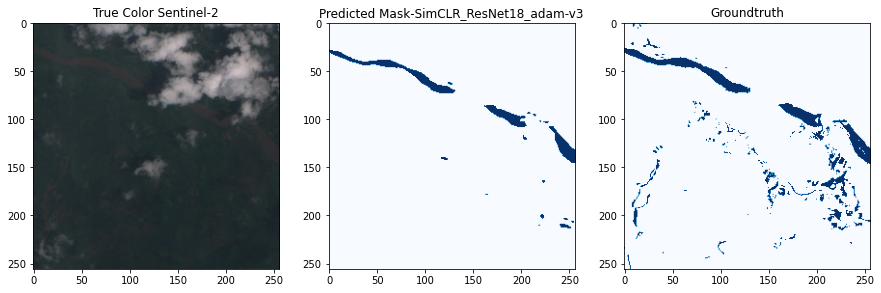

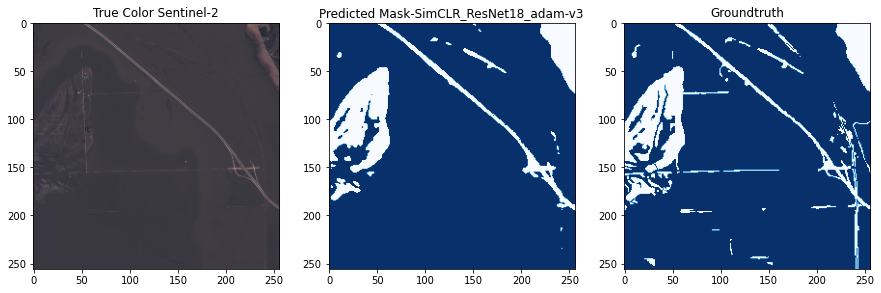

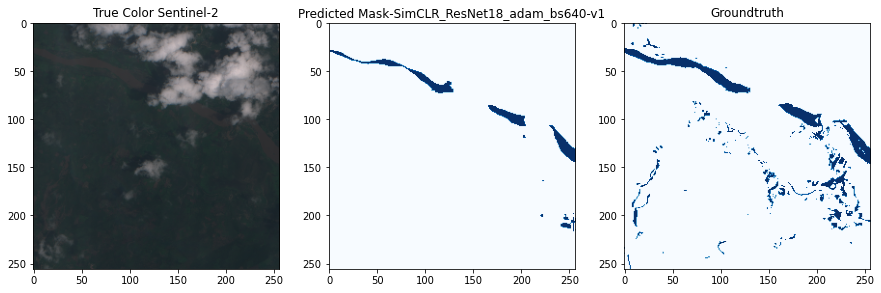

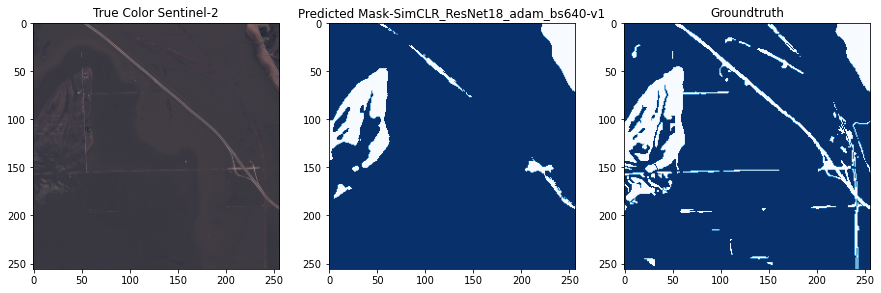

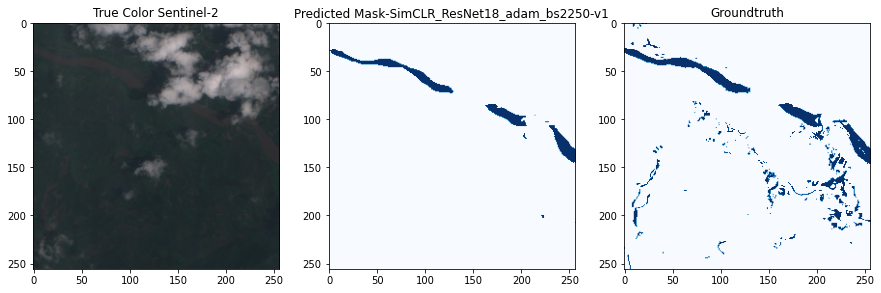

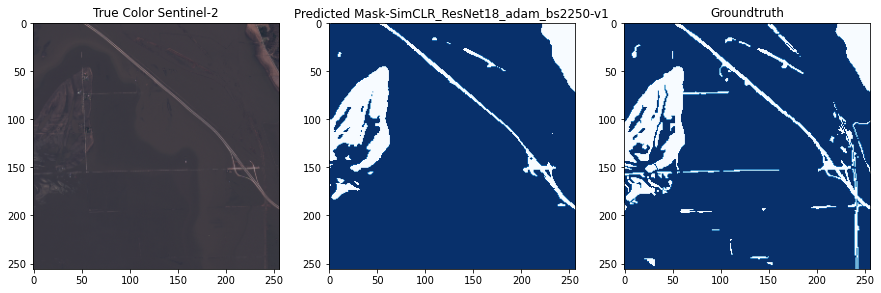

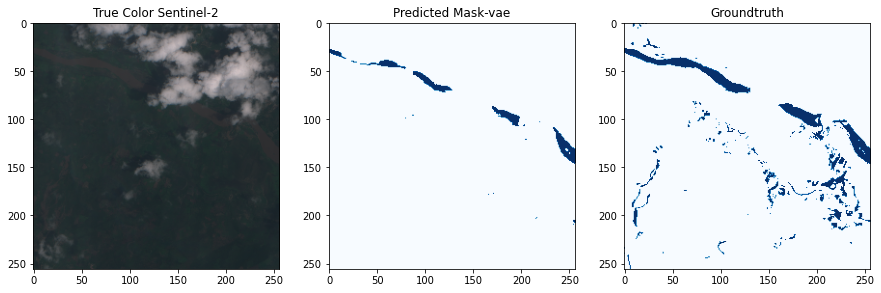

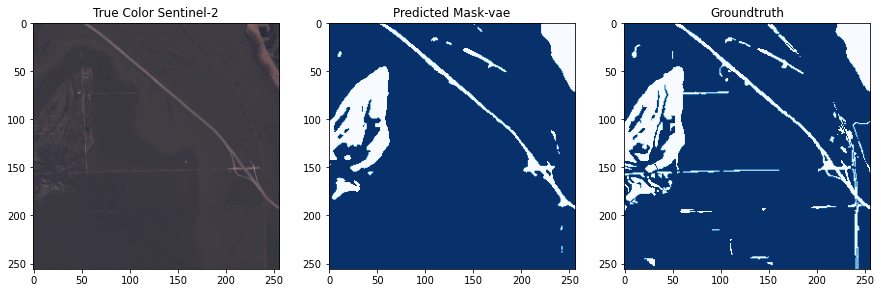

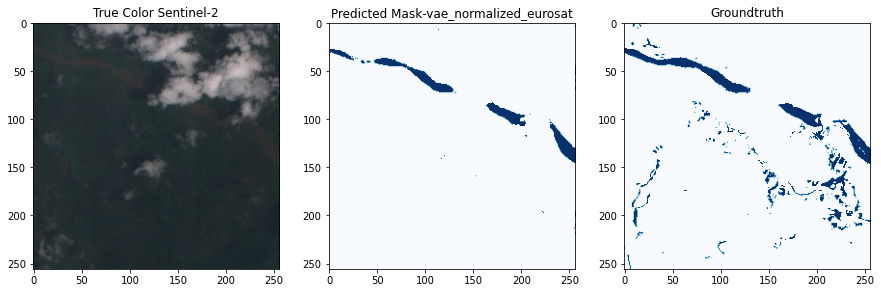

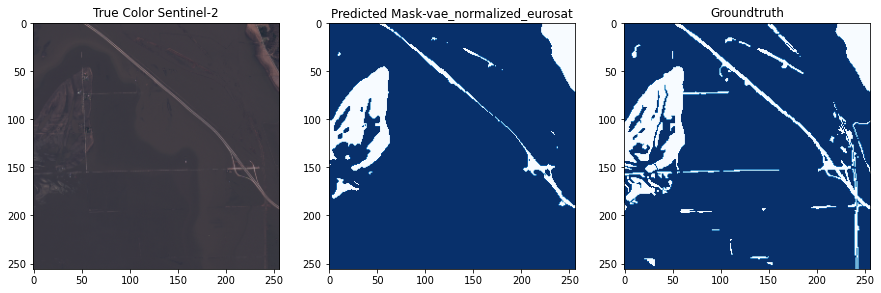

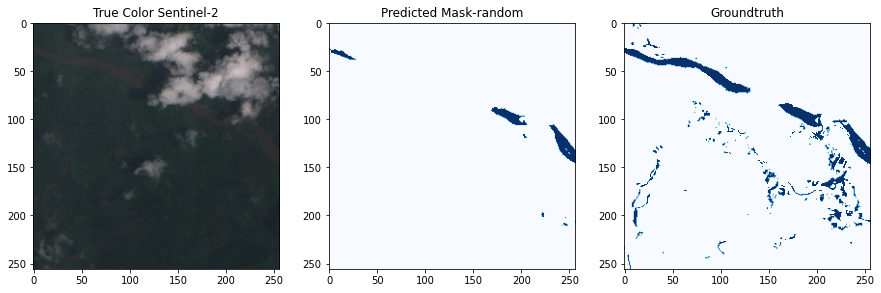

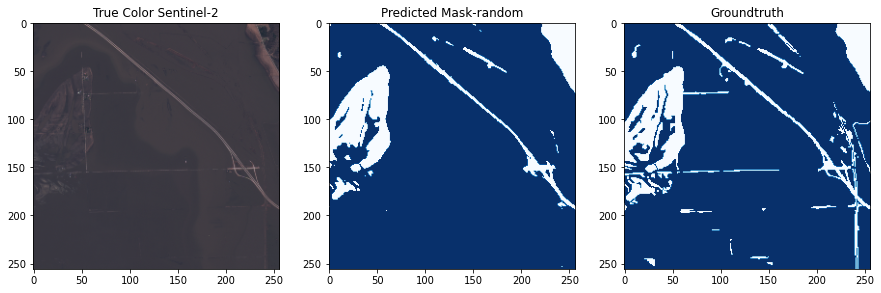

In [ ]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    patch_first_conv(encoder,13,default_in_channels=3)

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    model = ResNetUNet(1,encoder = encoder)

    # Initialise the optimizer
    if train_config.optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif train_config.optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs = train_config.epochs

    # Move the model to the GPU
    model.to(device)

    # Create lists for logging losses and evalualtion metrics:
    train_losses = []
    train_accs = []
    train_ious = []

    val_losses = []
    val_accs = []
    val_ious = []

    # IoU
    jaccard = JaccardIndex(num_classes=2).to(device)


    # For every epoch 
    for epoch in range(epochs):
        epoch_loss = 0
        progress = tqdm(
            enumerate(train_loader), desc="Train Loss: ",
            total=len(train_loader)
        )
        
        # Specify you are in training mode
        model.train()
        
        epoch_train_loss = 0
        epoch_val_loss = 0

        epoch_train_ious = 0
        epoch_val_ious = 0

        epoch_train_accs = 0
        epoch_val_accs = 0

        for i, batch in progress:
            # Transfer data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch['mask'].float().to(device)
            
            # Make a forward pass
            output = model(data)
            #print(output.shape)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(train_loader)

            # Compute pixel accuracies
            epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (len(train_loader) * (256*256) * 100)
            
            # Compute the loss
            loss = criterion(output, label.unsqueeze(1))
            
            # Clear the gradients
            optimizer.zero_grad()

            # Calculate gradients 
            loss.backward()

            # Update Weights
            optimizer.step()
            
            # Accumulate the loss over the eopch
            epoch_train_loss += loss / len(train_loader)

            progress.set_description("Epoch = {}, Train Loss: {:.4f}".format(epoch+1,
                                        epoch_train_loss))

        progress = tqdm(
            enumerate(val_loader), desc="val Loss: ",
            total=len(val_loader), position=0, leave=True,)
        
        # Specify you are in evaluation mode
        model.eval()
        
        # Deactivate autograd engine (no backpropagation allowed)
        with torch.no_grad():
            epoch_val_loss = 0
            for j, batch in progress:
                # Transfer Data to GPU if available
                data = batch["s2_img"].float().to(device)
                label = batch['mask'].float().to(device)

                # Make a forward pass
                output = model(data)

                # Derive binary segmentation map from prediction
                output_binary = torch.zeros(output.shape)
                output_binary[output >= 0] = 1

                # Compute IoU
                epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(val_loader)

                # Compute pixel accuracies
                epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (len(val_loader) * (256*256) * 100)
                
                # Compute the loss
                val_loss = criterion(output, label.unsqueeze(1))
                        
                # Accumulate the loss over the epoch
                epoch_val_loss += val_loss / len(val_loader)

                progress.set_description("Validation Loss: {:.4f}".format(
                                        epoch_val_loss))
        
        if epoch == 0:
            best_val_loss = epoch_val_loss
        else:
            if epoch_val_loss <= best_val_loss:
                best_val_loss = epoch_val_loss
                # Save only the best model
                torch.save(model.state_dict(), model_path)
                print('Saving Model...')

        # save result to wandb
        wandb.log({'train_loss_segmentation': epoch_train_loss, 'val_loss_segmentation': epoch_val_loss, 
                  'train_iou_segmentation': epoch_train_ious, 'val_iou_segmentation':epoch_val_ious,
                   'train_acc_segmentation': epoch_train_accs, 'val_acc_segmentation':epoch_val_accs})

        # print("Epoch = ", epoch+1)
        # Save losses in list, so that we can visualise them later. 
        train_losses.append(epoch_train_loss.cpu().detach().numpy())
        val_losses.append(epoch_val_loss.cpu().detach().numpy())

        # Save IoUs in list, so that we can visualise them later. 
        train_ious.append(epoch_train_ious.cpu().detach().numpy())
        val_ious.append(epoch_val_ious.cpu().detach().numpy())
        print(f'train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}')

        # Save accuracies in list, so that we can visualise them later. 
        train_accs.append(epoch_train_accs.cpu().detach().numpy())
        val_accs.append(epoch_val_accs.cpu().detach().numpy())
        print(f'train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}')

    print('Finished Training')

    # Initialise a UNet() model 
    ResNetUNet(1,encoder = encoder)
    # Load pretrained weights
    model.load_state_dict(torch.load(model_path))
    # Move to device (GPU or CPU)
    model.to(device);

    def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
        if not idx:
            idx = random.randint(0, len(valset))
        print('Validation image ID: {}'.format(idx))
        
        # Get Sentinel 2 and Sentinel 1 data
        s2_data = torch.unsqueeze(valset.__getitem__(idx)['s2_img'].float().to(device), 0)
        s1_data = torch.unsqueeze(valset.__getitem__(idx)['s1_img'].float().to(device), 0)
        
        # Get predictions from the model
        if multi:
            output = model(s1_data, s2_data)
        else:
            output = model(s2_data)
        
        # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1
        
        get_metrics(valset.__getitem__(idx)['mask'], output_binary)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 7))
        axes[0].imshow(np.transpose(valset.__getitem__(idx)['s2_img'][[3,2,1],:,:], (1, 2, 0)) / valset.__getitem__(idx)['s2_img'].max())
        axes[0].set_title('True Color Sentinel-2')
        axes[2].imshow(valset.__getitem__(idx)['mask'], cmap='Blues')
        axes[2].set_title(f'Groundtruth')
        axes[1].imshow(output_binary.squeeze(), cmap='Blues')
        axes[1].set_title(f'Predicted Mask-{model_name}')

    print("Sample image: ", model_name)
    display_outputs(37)
    display_outputs(127)

Function copied from: https://github.com/qubvel/segmentation_models.pytorch